<h1>UK Road Safety Analysis</h1>

<p>This notebook analyzes road accident data in the UK. The goal is to identify trends and patterns to improve road safety.</p>

<h2>Data Source & Representativeness</h2>
<p>
This dataset is derived from the <a href="https://data.gov.uk/dataset/road-accidents-safety-data" target="_blank">UK Department for Transport (DfT)</a> official road safety records. 
It contains police-reported road traffic accidents across multiple districts including Southend-on-Sea, Chelmsford, and Epping Forest. 
In total, the dataset includes approximately 300,000 rows, covering the period from <strong>1 January 2021 to 31 December 2022</strong>. Each row represents a reported accident record.
</p>

<p>
Because the data comes from official police records, it represents the full population of <strong>reported crashes</strong> within the covered geography and timeframe, rather than just a sample. 
However, very minor accidents that were never reported to the police are not included. 
As such, the analysis and predictions made in this project reflect trends in reported crashes, not all incidents that may occur on the road.
</p>

<h2>Data Overview</h2>
<p>The dataset contains information about road accidents in the UK, including:</p>
<ul>
  <li>Accident details (e.g. time, severity, location).</li>
  <li>Environmental conditions (e.g. weather, lighting, road surface).</li>
  <li>Junction and road characteristics (e.g. junction type, speed limit, road type).</li>
  <li>The number of casualties.</li>
</ul>
<p>With this structure, we can begin cleaning, exploring, and analyzing the data to identify meaningful patterns.</p>

<h2>Analysis</h2>
<ol>
  <li>Data Cleaning</li>
  <li>Exploratory Data Analysis & Visualization</li>
  <li>Predictions (Machine Learning Modeling)</li>
  <li>Conclusion</li>
</ol>

<hr>
<p><strong>Note:</strong> All results reflect <em>reported crashes</em> only. Unreported minor accidents are not included in this dataset.</p>



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

<h2>Loading the Data, Cleaning, and Formatting</h2>
<p>First, we load the data using Pandas and use <code>.head()</code> to preview the dataset. This allows us to see the structure of the data and decide which columns will be most useful for generating insights.</p>


In [4]:
data = pd.read_csv('Road Accident Data.csv')

data.head()

,Accident_Index,Accident Date,Day_of_Week,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,Local_Authority_(District),Carriageway_Hazards,...,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
0,BS0000001,01-01-2021,Thursday,Give way or uncontrolled,T or staggered junction,Serious,51.512273,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,One way street,30,15:11,Urban,Fine no high winds,Car
1,BS0000002,05-01-2021,Monday,Give way or uncontrolled,Crossroads,Serious,51.514399,Daylight,Kensington and Chelsea,NaN,...,11,2,Metropolitan Police,Wet or damp,Single carriageway,30,10:59,Urban,Fine no high winds,Taxi/Private hire car
2,BS0000003,04-01-2021,Sunday,Give way or uncontrolled,T or staggered junction,Slight,51.486668,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,Single carriageway,30,14:19,Urban,Fine no high winds,Taxi/Private hire car
3,BS0000004,05-01-2021,Monday,Auto traffic signal,T or staggered junction,Serious,51.507804,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Frost or ice,Single carriageway,30,08:10,Urban,Other,Motorcycle over 500cc
4,BS0000005,06-01-2021,Tuesday,Auto traffic signal,Crossroads,Serious,51.482076,Darkness - lights lit,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,Single carriageway,30,17:25,Urban,Fine no high winds,Car


<p>Next, we will remove all the columns that we won’t be using by applying the <code>.drop()</code> method to the DataFrame. After dropping these columns, we use <code>.info()</code> to check which columns remain and to verify whether there is any missing data in the dataset.</p>

<p><strong>Edit:</strong> During my analysis, I discovered a typo in the <code>severity</code> column: 'fetal' instead of 'fatal'. This was corrected to ensure accurate results.</p>

In [5]:
data['Accident_Severity'] = data['Accident_Severity'].replace({'Fetal': 'Fatal'})

data.drop(['Carriageway_Hazards', 'Police_Force', 'Vehicle_Type', 'Accident_Index', 'Latitude', 'Longitude'], axis=1, inplace=True, errors='ignore')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307973 entries, 0 to 307972
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Accident Date               307973 non-null  object
 1   Day_of_Week                 307973 non-null  object
 2   Junction_Control            307973 non-null  object
 3   Junction_Detail             307973 non-null  object
 4   Accident_Severity           307973 non-null  object
 5   Light_Conditions            307973 non-null  object
 6   Local_Authority_(District)  307973 non-null  object
 7   Number_of_Casualties        307973 non-null  int64 
 8   Number_of_Vehicles          307973 non-null  int64 
 9   Road_Surface_Conditions     307973 non-null  object
 10  Road_Type                   307973 non-null  object
 11  Speed_limit                 307973 non-null  int64 
 12  Time                        307956 non-null  object
 13  Urban_or_Rural_Area         3

<p>Before we start exploring the data, we convert the Time column into a 64-bit datetime object. This allows us to perform various calculations when analyzing the dataset. For example, converting the column enables us to calculate the median time, which would not be possible if it were stored as plain strings.</p>
<p>We then use this median value to fill in any missing Time entries that were identified in the previous step. Finally, we verify the changes using .<code>info()</code> and <code>.head()</code> to confirm the column was updated correctly.</p>
<p><bold>Note: All times now display with the date 1900-01-01. This is simply a placeholder added by Pandas when creating a full datetime object. It does not affect calculations or the accuracy of the time values</bold></p>

In [6]:
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M', errors='coerce')

data['Accident Date'] = pd.to_datetime(data['Accident Date'], format='%d-%m-%Y', errors='coerce')

median_time = data['Time'].median()
data['Time'] = data['Time'].fillna(median_time)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307973 entries, 0 to 307972
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Accident Date               307973 non-null  datetime64[ns]
 1   Day_of_Week                 307973 non-null  object        
 2   Junction_Control            307973 non-null  object        
 3   Junction_Detail             307973 non-null  object        
 4   Accident_Severity           307973 non-null  object        
 5   Light_Conditions            307973 non-null  object        
 6   Local_Authority_(District)  307973 non-null  object        
 7   Number_of_Casualties        307973 non-null  int64         
 8   Number_of_Vehicles          307973 non-null  int64         
 9   Road_Surface_Conditions     307973 non-null  object        
 10  Road_Type                   307973 non-null  object        
 11  Speed_limit                 307973 non-

,Accident Date,Day_of_Week,Junction_Control,Junction_Detail,Accident_Severity,Light_Conditions,Local_Authority_(District),Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions
0,2021-01-01,Thursday,Give way or uncontrolled,T or staggered junction,Serious,Daylight,Kensington and Chelsea,1,2,Dry,One way street,30,1900-01-01 15:11:00,Urban,Fine no high winds
1,2021-01-05,Monday,Give way or uncontrolled,Crossroads,Serious,Daylight,Kensington and Chelsea,11,2,Wet or damp,Single carriageway,30,1900-01-01 10:59:00,Urban,Fine no high winds
2,2021-01-04,Sunday,Give way or uncontrolled,T or staggered junction,Slight,Daylight,Kensington and Chelsea,1,2,Dry,Single carriageway,30,1900-01-01 14:19:00,Urban,Fine no high winds
3,2021-01-05,Monday,Auto traffic signal,T or staggered junction,Serious,Daylight,Kensington and Chelsea,1,2,Frost or ice,Single carriageway,30,1900-01-01 08:10:00,Urban,Other
4,2021-01-06,Tuesday,Auto traffic signal,Crossroads,Serious,Darkness - lights lit,Kensington and Chelsea,1,2,Dry,Single carriageway,30,1900-01-01 17:25:00,Urban,Fine no high winds


<h2>Exploratory Data Analysis & Visualization</h2>

<p>
In this section, we begin exploring the dataset to uncover patterns and insights.  
We start by examining <strong>which days of the week crashes are more likely to occur</strong>.  
This helps us understand whether accidents cluster around weekdays, weekends, or specific days, providing valuable context for road safety planning. 
</p>

In [7]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

data['Day_of_Week'] = pd.Categorical(data['Day_of_Week'], categories=day_order, ordered=True)

day_counts = data['Day_of_Week'].value_counts().sort_index()

print(day_counts)

Day_of_Week
Monday       43918
Tuesday      46386
Wednesday    46381
Thursday     45649
Friday       50529
Saturday     41566
Sunday       33544
Name: count, dtype: int64


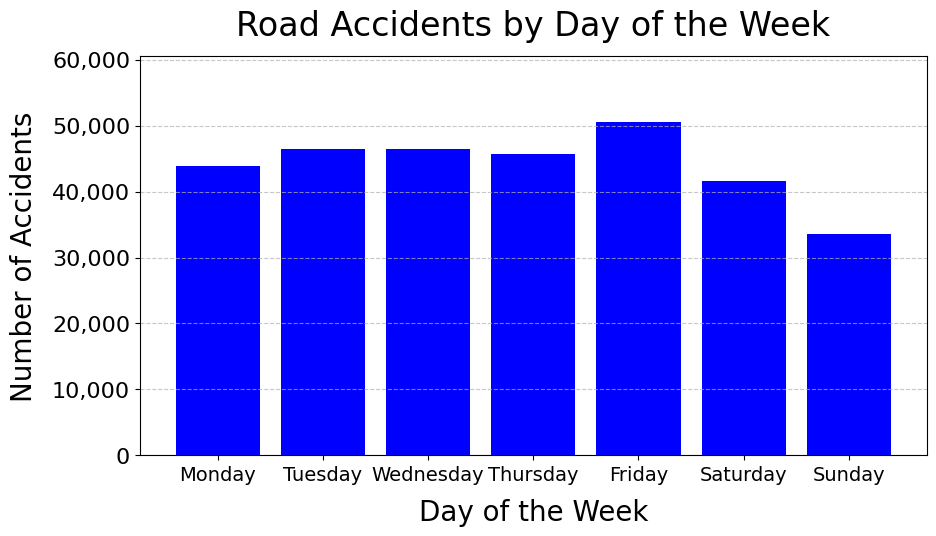

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(day_counts.index, day_counts.values, color='blue')
plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)
plt.title('Road Accidents by Day of the Week', fontsize=24, pad=15)
plt.xlabel('Day of the Week', fontsize=20, labelpad=10)
plt.ylabel('Number of Accidents', fontsize=20, labelpad=10)
plt.ylim(0, day_counts.max() + 10000)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xticks(fontsize=14)
plt.yticks(fontsize=16)
plt.tight_layout(pad=3.0)
plt.show()

In [9]:
monday_to_thursday = day_counts.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday']]

average_mon_to_thu = monday_to_thursday.mean()

print(f'Average total accidents from Monday to Thursday over two years: {average_mon_to_thu:.0f}')

friday_accidents = day_counts.loc['Friday']
saturday_accidents = day_counts.loc['Saturday']
sunday_accidents = day_counts.loc['Sunday']

fri_increase_pct = ((friday_accidents - average_mon_to_thu) / average_mon_to_thu) * 100
fri_increase_num = friday_accidents - average_mon_to_thu

sat_decrease_pct = ((saturday_accidents - friday_accidents) / friday_accidents) * 100
sat_decrease_num = saturday_accidents - friday_accidents

sun_decrease_pct = ((sunday_accidents - average_mon_to_thu) / average_mon_to_thu) * 100
sun_decrease_num = sunday_accidents - average_mon_to_thu

print(f'Friday total accidents: {friday_accidents}')
print(f'Increase from Mon–Thu average: {fri_increase_num:.0f} accidents ({fri_increase_pct:.2f}%)')

print(f'Saturday total accidents: {saturday_accidents}')
print(f'Decrease from Friday: {abs(sat_decrease_num):.0f} accidents ({abs(sat_decrease_pct):.2f}%)')

print(f'Sunday total accidents: {sunday_accidents}')
print(f'Decrease from Mon–Thu average: {abs(sun_decrease_num):.0f} accidents ({abs(sun_decrease_pct):.2f}%)')


Average total accidents from Monday to Thursday over two years: 45584
Friday total accidents: 50529
Increase from Mon–Thu average: 4946 accidents (10.85%)
Saturday total accidents: 41566
Decrease from Friday: 8963 accidents (17.74%)
Sunday total accidents: 33544
Decrease from Mon–Thu average: 12040 accidents (26.41%)


<p>Looking at this chart, we see that Monday through Thursday have similar totals, around <strong>45,583</strong> accidents each over the two-year period.</p>
<p>On Friday, accidents increase by <strong>10.85%</strong>, reaching a total of <strong>50,528</strong> accidents.</p>
<p>Accidents then decrease on Saturday by <strong>18.74%</strong>, and drop further on Sunday to <strong>33,544</strong> accidents, representing a <strong>26.4%</strong> decrease from the Monday–Thursday baseline.</p>

<h3>My Observations</h3>
<p>The data suggests that accident patterns are fairly consistent from Monday to Thursday, leading to relatively stable accident numbers. On Friday, we see a <strong>10.85%</strong> increase in accidents. This could indicate that people are rushing home from work to start their weekend, and that increased activity in town centres at night may also be a factor.</p>
<p>Accidents then decline on Saturday and Sunday, most likely due to fewer people working. On Sundays in particular, shops being closed and many people using the day to relax may contribute to the lower totals.</p>

<ul>
  <li>Monday–Thursday: Stable accident patterns and counts.</li>
  <li>Friday: 10.85% increase in accidents, likely due to higher evening activity and weekend travel.</li>
  <li>Saturday: Decrease in accidents as fewer people commute.</li>
  <li>Sunday: Further decrease; leisure day and closed shops may reduce activity.</li>
</ul>

<p>Next, we will examine the severity of crashes, classified as slight, serious, or fatal, for each day of the week. Since fatal accidents make up a very small percentage of the total, we will separate them to make the analysis clearer. After this, we will explore where these crashes typically occur.</p>


/var/folders/kv/ltq69y3n6_d77_rbwry_1rch0000gn/T/ipykernel_78731/3388550508.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_counts = data.groupby(['Day_of_Week', 'Accident_Severity']).size().unstack()


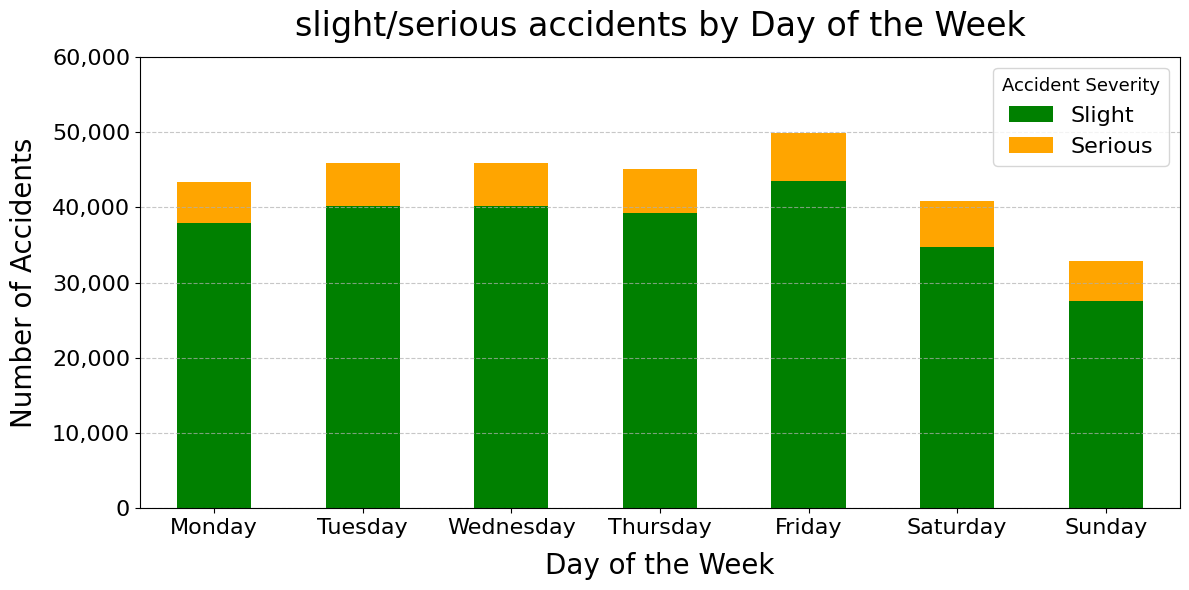

In [10]:
severity_counts = data.groupby(['Day_of_Week', 'Accident_Severity']).size().unstack()
slight_serious_counts = severity_counts[['Slight', 'Serious']]

slight_serious_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=['green', 'orange'])
plt.title('slight/serious accidents by Day of the Week', fontsize=24, pad=15)
plt.xlabel('Day of the Week', fontsize=20, labelpad=10)
plt.ylabel('Number of Accidents', fontsize=20, labelpad=10)
plt.xticks(fontsize=16, rotation=0,)
plt.yticks(fontsize=16)
plt.ylim(0, 60000)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.legend(title='Accident Severity', fontsize=16, title_fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

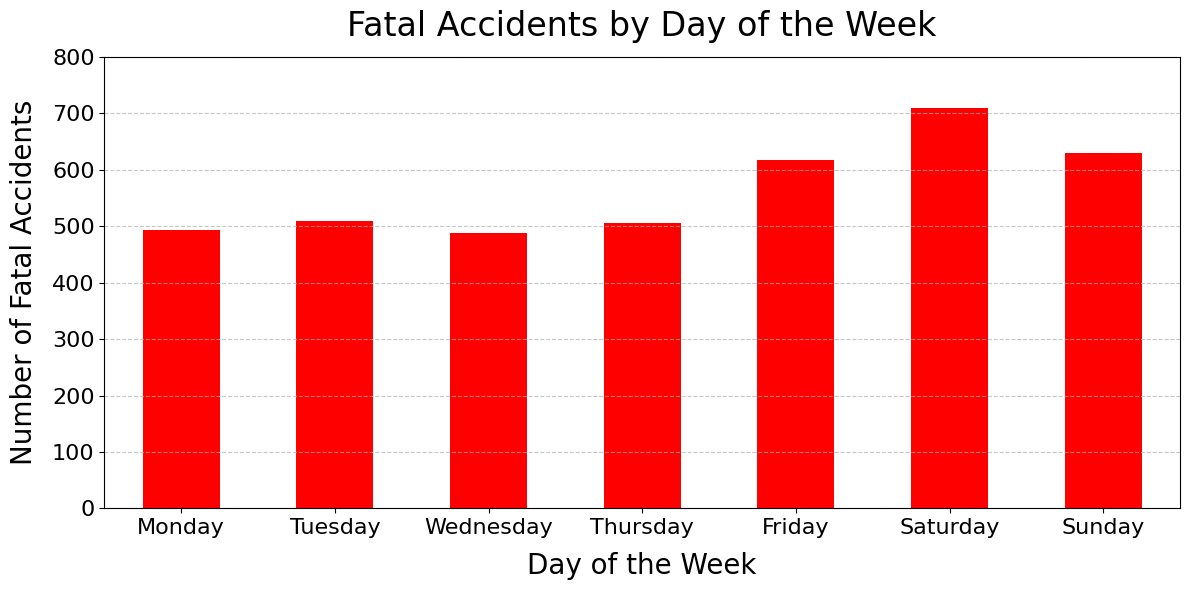

In [11]:
fatal_counts = severity_counts['Fatal']

fatal_counts.plot(kind='bar', figsize=(12, 6), color='red')
plt.title('Fatal Accidents by Day of the Week', fontsize=24, pad=15)
plt.xlabel('Day of the Week', fontsize=20, labelpad=10)
plt.ylabel('Number of Fatal Accidents', fontsize=20, labelpad=10)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.ylim(0, 800)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
fatal_percentage = (fatal_counts / day_counts) * 100
print('Fatal percentage by day of the week:')
print(fatal_percentage.round(2))

fatal_percentage_average = fatal_percentage.mean()
print('Average fatal percentage:')
print(fatal_percentage_average.round(2))

monday_thursday_fatal = fatal_counts[['Monday', 'Tuesday', 'Wednesday', 'Thursday']]
monday_thursday_fatal_average = monday_thursday_fatal.mean()
print('Average fatal accidents (Monday - Thursday):')
print(monday_thursday_fatal_average.round())

friday_fatal = fatal_counts['Friday']
print('fatal accidents (Friday):')
print(friday_fatal)

saturday_fatal = fatal_counts['Saturday']
print('fatal accidents (Saturday):')
print(saturday_fatal)

sunday_fatal = fatal_counts['Sunday']
print('fatal accidents (Sunday):')
print(sunday_fatal)

total_fatal_percent = (fatal_counts.sum() / day_counts.sum()) * 100
print('Total fatal accidents percentage:')
print(total_fatal_percent.round(2))

Fatal percentage by day of the week:
Day_of_Week
Monday       1.12
Tuesday      1.10
Wednesday    1.05
Thursday     1.11
Friday       1.22
Saturday     1.71
Sunday       1.88
dtype: float64
Average fatal percentage:
1.31
Average fatal accidents (Monday - Thursday):
499.0
fatal accidents (Friday):
617
fatal accidents (Saturday):
710
fatal accidents (Sunday):
629
Total fatal accidents percentage:
1.28


<p>Looking at both charts, we see that from Monday to Thursday the pattern remains consistent with our earlier findings. On Friday, slight and serious accidents follow the expected trend of rising sharply before declining over the weekend.</p> <p>In contrast, fatal accidents increase from a weekday average of around <strong>499</strong> crashes (per day across two years) to <strong>617 on Friday</strong>, peaking at <strong>710 on Saturday</strong>, before dropping slightly to <strong>629 on Sunday</strong>. While this rise might seem alarming, fatal crashes remain relatively rare — they account for only <strong>1.28%</strong> of all crashes in the dataset, averaging <strong>1.31%</strong> on any given day, with weekends consistently higher than weekdays.</p>

<h3>My Observations</h3>
<p>The data suggests that while overall accidents tend to be lower over the weekend, the proportion of fatal accidents increases. This indicates that changes in driving behaviour, rather than just traffic volume, may influence accident severity.</p>

<ul>
  <li>Higher speeds on less congested roads</li>
  <li>Increased leisure travel over the weekend</li>
  <li>Alcohol consumption potentially contributing to riskier driving</li>
  <li>Less traffic enforcement or monitoring during weekend hours</li>
</ul>

<p>Next, we will zoom in to examine <strong>what time these crashes typically occur</strong>, before stepping back to review the <strong>overall patterns across the two-year period</strong>.</p>


In [13]:
time_of_day = data.groupby(['Time', 'Day_of_Week', 'Accident_Severity']).size().reset_index(name='Accident_Count')

print(time_of_day.head())

                 Time Day_of_Week Accident_Severity  Accident_Count
0 1900-01-01 00:01:00      Monday             Fatal               3
1 1900-01-01 00:01:00      Monday           Serious               8
2 1900-01-01 00:01:00      Monday            Slight              37
3 1900-01-01 00:01:00     Tuesday             Fatal               1
4 1900-01-01 00:01:00     Tuesday           Serious              11


/var/folders/kv/ltq69y3n6_d77_rbwry_1rch0000gn/T/ipykernel_78731/2734498262.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_of_day = data.groupby(['Time', 'Day_of_Week', 'Accident_Severity']).size().reset_index(name='Accident_Count')


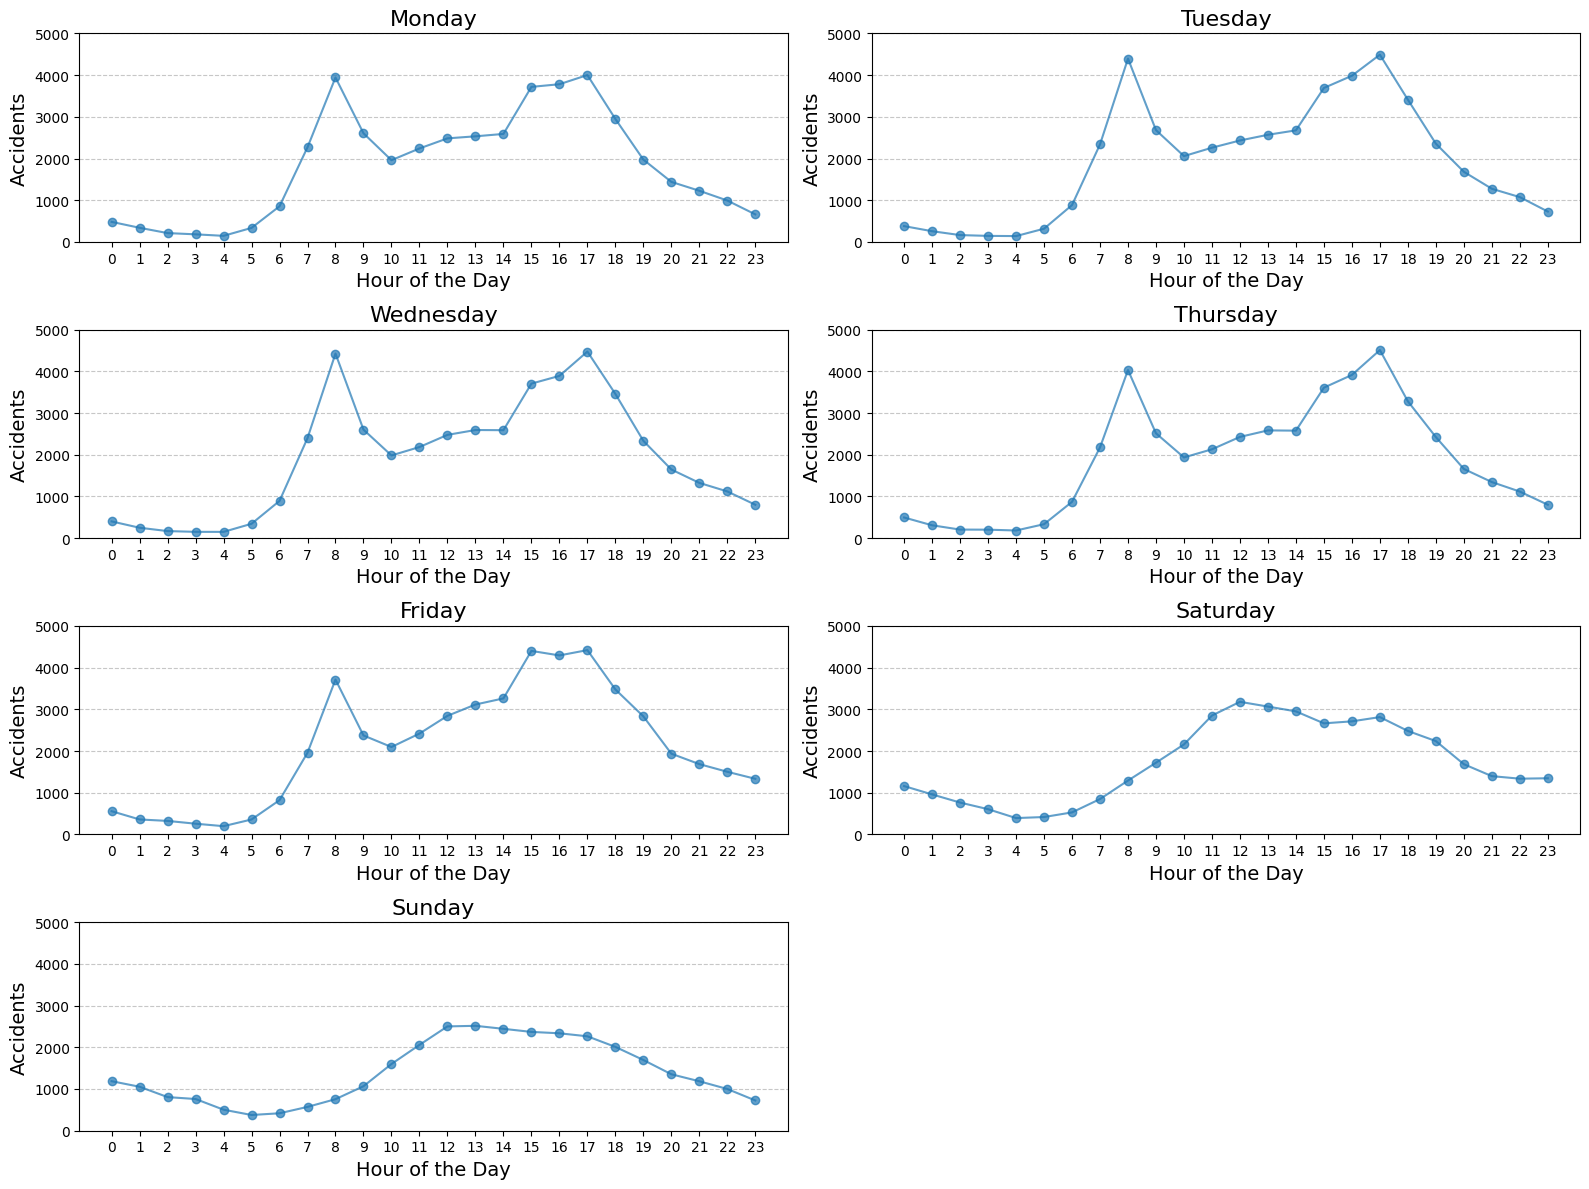

In [14]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12))
axes = axes.flatten() 

for i, day in enumerate(days):
    if i < len(axes):
        day_data = time_of_day[time_of_day['Day_of_Week'] == day]
        day_data = day_data.copy()
        day_data['Hour'] = day_data['Time'].dt.hour
        hourly_data = day_data.groupby('Hour')['Accident_Count'].sum().reset_index()

        axes[i].plot(hourly_data['Hour'], hourly_data['Accident_Count'], marker='o', linestyle='-', alpha=0.7)
        axes[i].set_title(day, fontsize=16)
        axes[i].set_xlabel('Hour of the Day', fontsize=14)
        axes[i].set_xticks(hourly_data['Hour'])
        axes[i].set_xticklabels(hourly_data['Hour'], fontsize=10)
        axes[i].set_ylabel('Accidents', fontsize=14)
        axes[i].set_ylim(0,5000)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

for j in range(len(days), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [15]:
data['Hour'] = data['Time'].dt.hour

day_hourly_data = data.groupby(['Day_of_Week', 'Hour']).size().reset_index(name='Accident_Count')

monday_thursday_hourly_average = day_hourly_data[day_hourly_data['Day_of_Week'].isin(['Monday', 'Tuesday', 'Wednesday' 'Thursday'])].groupby('Hour')['Accident_Count'].mean().reset_index()

print(monday_thursday_hourly_average)

    Hour  Accident_Count
0      0           431.0
1      1           299.0
2      2           189.0
3      3           164.5
4      4           144.0
5      5           327.5
6      6           869.5
7      7          2303.5
8      8          4168.0
9      9          2642.5
10    10          2009.0
11    11          2250.0
12    12          2457.5
13    13          2550.5
14    14          2632.0
15    15          3704.0
16    16          3881.5
17    17          4244.0
18    18          3179.0
19    19          2165.0
20    20          1561.0
21    21          1251.0
22    22          1034.0
23    23           695.0


/var/folders/kv/ltq69y3n6_d77_rbwry_1rch0000gn/T/ipykernel_78731/2261322305.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_hourly_data = data.groupby(['Day_of_Week', 'Hour']).size().reset_index(name='Accident_Count')


In [16]:
friday_hourly_data = day_hourly_data[day_hourly_data['Day_of_Week'].isin(['Friday'])].groupby('Hour')['Accident_Count'].sum().reset_index()

friday_hourly_data = day_hourly_data[day_hourly_data['Day_of_Week'].isin(['Friday'])].groupby('Hour')['Accident_Count'].sum().reset_index()

print(friday_hourly_data)

    Hour  Accident_Count
0      0             558
1      1             360
2      2             325
3      3             258
4      4             199
5      5             359
6      6             822
7      7            1959
8      8            3712
9      9            2373
10    10            2096
11    11            2418
12    12            2843
13    13            3114
14    14            3261
15    15            4399
16    16            4291
17    17            4418
18    18            3476
19    19            2830
20    20            1936
21    21            1686
22    22            1502
23    23            1334


In [17]:
saturday_hourly_data = day_hourly_data[day_hourly_data['Day_of_Week'].isin(['Saturday'])].groupby('Hour')['Accident_Count'].sum().reset_index()

sat_max_accidents = saturday_hourly_data.loc[saturday_hourly_data['Accident_Count'].idxmax()]
sat_min_accidents = saturday_hourly_data.loc[saturday_hourly_data['Accident_Count'].idxmin()]

print("Hour with the highest accidents on Saturday:")
print(sat_max_accidents)

print("\nHour with the lowest accidents on Saturday:")
print(sat_min_accidents)

Hour with the highest accidents on Saturday:
Hour                12
Accident_Count    3179
Name: 12, dtype: int64

Hour with the lowest accidents on Saturday:
Hour                4
Accident_Count    393
Name: 4, dtype: int64


In [18]:
sunday_hourly_data = day_hourly_data[day_hourly_data['Day_of_Week'].isin(['Sunday'])].groupby('Hour')['Accident_Count'].sum().reset_index()

sun_max_accidents = sunday_hourly_data.loc[sunday_hourly_data['Accident_Count'].idxmax()]
sun_min_accidents = sunday_hourly_data.loc[sunday_hourly_data['Accident_Count'].idxmin()]

print("Hour with the highest accidents on Sunday:")
print(sun_max_accidents)

print("\nHour with the lowest accidents on Sunday:")
print(sun_min_accidents)

Hour with the highest accidents on Sunday:
Hour                13
Accident_Count    2514
Name: 13, dtype: int64

Hour with the lowest accidents on Sunday:
Hour                5
Accident_Count    377
Name: 5, dtype: int64


<p>Viewing the charts and corresponding data, we see that from Monday to Thursday there are typically two clear spikes in accidents. The first occurs in the morning, starting around <strong>7 AM</strong> and peaking at <strong>8 AM</strong> with an average of <strong>4,168 crashes</strong>, before beginning to decline after <strong>9 AM</strong>. Crash levels then remain in the 2,000s throughout the late morning and early afternoon, before rising sharply again from <strong>3 PM</strong> and reaching a second peak at <strong>5 PM</strong> with an average of <strong>4,244 crashes</strong>.</p>

<p>Friday follows a similar pattern in the morning, with crashes starting to rise at <strong>7 AM</strong> and peaking at <strong>8 AM</strong> with <strong>3,712 crashes</strong>. Levels then decline slightly to around <strong>2,373 crashes</strong> through late morning and early afternoon. However, unlike Monday to Thursday, the peak starts at <strong>3 pm with 4,399 crashes</strong> and remain elevated above 4,000 through to <strong>5 PM</strong>, before tapering off but unlike the other days crashes stay above 1,000 until 1 am saturday morning.</p>

<p>Across the weekend, crash patterns are more steady without the sharp peaks seen during the week. On Saturday, crashes reach their lowest point at <strong>393</strong> around <strong>4 AM</strong>, then gradually increase throughout the day, peaking at <strong>3,179 crashes</strong> around <strong>12 PM</strong>, before slowly declining into the evening. On Sunday, crashes similarly bottom out at <strong>377</strong> around <strong>5 AM</strong>, followed by a steady rise to a smaller peak of <strong>2,514 crashes</strong> at <strong>1 PM</strong>, after which the numbers begin to taper off again.</p>

<h3>My Observations</h3>

<p>It is reasonable to assume that from Monday to Friday, the increases in accidents are linked to work and school travel patterns. Morning peaks typically appear between <strong>7 AM and 9 AM</strong>, while afternoon crashes begin to rise around <strong>3 PM</strong> (likely influenced by school pick-ups and early commuters), before reaching a clear peak at <strong>5 PM</strong> when most people leave work. From Monday to Thursday, crash counts taper off fairly quickly after this point. On Friday, however, crash counts remain above <strong>1,000</strong> until <strong>1 AM</strong>, which may reflect people staying out later for weekend leisure activities.</p>

<p>Over the weekend, accident patterns differ from the sharp commuter-driven spikes seen on weekdays. Instead, we observe a smoother, wave-like trend, with crashes gradually increasing through the morning, peaking around midday, and then steadily declining into the evening. This is likely influenced by leisure activities, with people traveling more freely compared to the structured routines of school and work during the week.</p>

<ul>
  <li><strong>Weekdays:</strong> Clear morning (7–9 AM) and evening (5 PM) peaks tied to commuting patterns.</li>
  <li><strong>Friday:</strong> Follows weekday trends but maintains higher crash levels into late evening and early morning hours.</li>
  <li><strong>Weekend:</strong> Lacks sharp commuter peaks; accidents rise steadily, peak around midday, then taper off.</li>
  <li><strong>Possible factors:</strong> Leisure travel, reduced structure compared to weekdays, and late-night activities on Fridays.</li>
</ul>

<p>Now that we’ve examined daily and hourly patterns, we will take a step back and explore yearly trends. This will allow us to see whether accident patterns remain consistent over time or if there are notable shifts from year to year. Finally, we will apply machine learning techniques to investigate whether these patterns can be used to make predictions.</p>

<p><em>Note:</em> While it is possible to break down hourly crashes further by severity (slight, serious, and fatal), the patterns would largely mirror the overall hourly trends shown here. Fatal crashes in particular are too rare to produce meaningful hourly patterns, so we have chosen to focus on total crashes for clarity.</p>


In [21]:
yearly_accidents = data.groupby('Accident Date').size()

print(yearly_accidents)

Accident Date
2021-01-01    244
2021-01-02    298
2021-01-03    341
2021-01-04    292
2021-01-05    471
             ... 
2022-12-27    179
2022-12-28    181
2022-12-29    214
2022-12-30    171
2022-12-31    193
Length: 730, dtype: int64


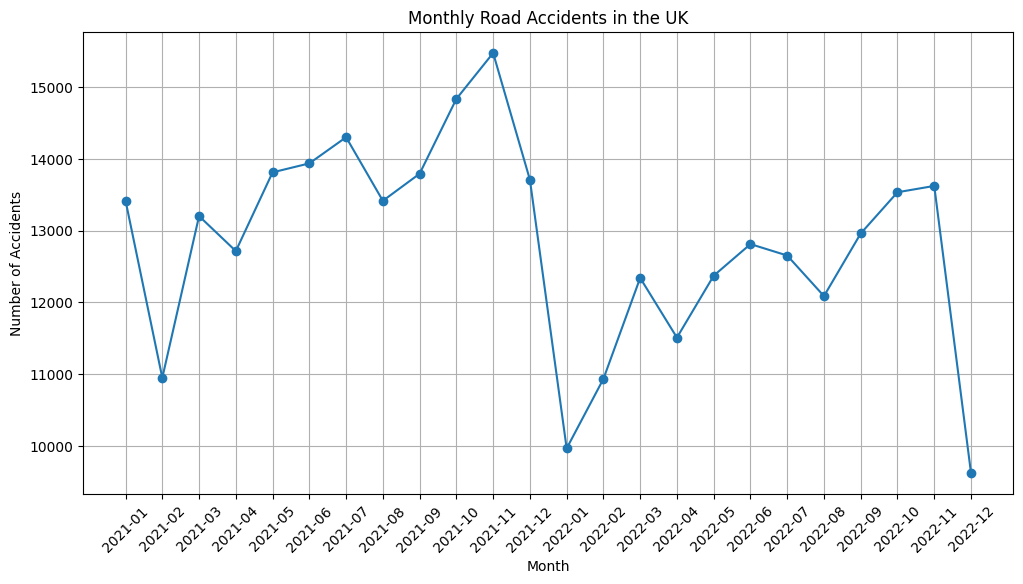

In [ ]:
monthly_accidents = data.groupby(data['Accident Date'].dt.to_period('M')).size()

plt.figure(figsize=(12, 6))
plt.plot(monthly_accidents.index.astype(str), monthly_accidents.values, marker='o')
plt.title('Monthly Road Accidents in the UK')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.grid()
plt.xticks(rotation=45)
plt.show()